#### First download the station data for the Gulf States (TX, LA, AL, MS, FL)
#### Then clip the stations to the watershed counties 
#### Use the station names to build a URL and access the narrow results from the EPA Water Quality API

### URL Examples
##### EPA Water Quality Site:
##### https://www.waterqualitydata.us/

##### Download all the stations for USA states FL, AL, TX, MS, LA as a GEOJSON:
##### https://www.waterqualitydata.us/data/Station/search?countrycode=US&statecode=US%3A01&statecode=US%3A12&statecode=US%3A48&statecode=US%3A28&statecode=US%3A22&mimeType=geojsonv&zip=yes&providers=NWIS&providers=STEWARDS&providers=STORET

##### Download all the sample data for a given station (0800257-CC-05) as a CSV:
##### https://www.waterqualitydata.us/data/Result/search?siteid=0800257-CC-05&mimeType=csv&zip=yes&dataProfile=narrowResult&providers=NWIS&providers=STEWARDS&providers=STORET

#### Arcpy Reference: https://developers.arcgis.com/python/api-reference/

In [1]:
import arcpy
import arcgis
from arcgis.gis import GIS
#from arcgis.mapping import WebMap
from datetime import datetime
from datetime import timedelta
import urllib.request
import os
import pandas
import glob
gis = GIS("home")
arcpy.env.overwriteOutput = True
arcgis.env.verbose = True 

In [2]:
ROOT = r'C:\Temp\EPA-Water-Quality' #TODO Change to your preferred directory
TODAY = (datetime.today())
CURRENT_DATE = (TODAY.strftime('%Y%m%d'))
#WATER_QUALITY_STATIONS_URL = 'https://www.waterqualitydata.us/data/Station/search?countrycode=US&statecode=US%3A01&countycode=US%3A01%3A003&mimeType=geojson&zip=yes&providers=NWIS&providers=STEWARDS&providers=STORET'
WATER_QUALITY_STATIONS_URL = 'https://www.waterqualitydata.us/data/Station/search?countrycode=US&statecode=US%3A01&statecode=US%3A12&statecode=US%3A22&statecode=US%3A28&statecode=US%3A48&mimeType=geojson&zip=yes&providers=NWIS&providers=STEWARDS&providers=STORET'
WORKING_DIRECTORY = ROOT + '\\working_' + str(CURRENT_DATE) + '\\'
WATER_QUALITY_STATIONS_DIRECTORY = WORKING_DIRECTORY + '\\stations\\'
WATER_QUALITY_STATIONS_ZIP = WATER_QUALITY_STATIONS_DIRECTORY + 'water_quality_stations.zip'
WORKING_STATIONS_JSON = WORKING_DIRECTORY + 'station.geojson'
WORKING_STATIONS_SHP  = WORKING_DIRECTORY + 'station.shp'
CLIPPED_STATIONS = WORKING_DIRECTORY + 'goma_stations.shp'
COASTAL_COUNTIES = WORKING_DIRECTORY + 'coastal_watershed_counties.shp'
CSV_WORKING_DIRECTORY = WORKING_DIRECTORY + 'csv\\'

In [3]:
if not os.path.exists(ROOT):
    os.makedirs(ROOT)
if not os.path.exists(WORKING_DIRECTORY):
    os.makedirs(WORKING_DIRECTORY)
if not os.path.exists(CSV_WORKING_DIRECTORY):
    os.makedirs(CSV_WORKING_DIRECTORY)
if not os.path.exists(WATER_QUALITY_STATIONS_DIRECTORY):
    os.makedirs(WATER_QUALITY_STATIONS_DIRECTORY)

<Item title:"coastal_watershed_counties_2010" type:Feature Layer Collection owner:kvangraafeiland_oceans>
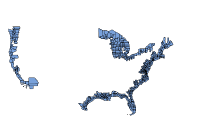

In [4]:
## Clip the stations to the specified polygon boundary 

## coastal_watershed_counties item id = ff61c0c5154d4791ae51f00c4e4a3a98
coastal_watershed_counties_item = gis.content.get('ff61c0c5154d4791ae51f00c4e4a3a98')
coastal_watershed_counties_item

In [5]:
coastal_watershed_counties_layer = coastal_watershed_counties_item.layers[0]
coastal_watershed_counties_layer

<FeatureLayer url:"https://services.arcgis.com/bDAhvQYMG4WL8O5o/arcgis/rest/services/coastal_watershed_counties_2010/FeatureServer/0">

In [6]:
urllib.request.urlretrieve(WATER_QUALITY_STATIONS_URL, WATER_QUALITY_STATIONS_ZIP)

In [ ]:
import zipfile
with zipfile.ZipFile(WATER_QUALITY_STATIONS_ZIP, 'r') as zip_ref:
    zip_ref.extractall(WORKING_DIRECTORY)

In [ ]:
arcpy.conversion.JSONToFeatures(WORKING_STATIONS_JSON, WORKING_STATIONS_SHP, geometry_type="POINT")

In [ ]:
arcpy.analysis.PairwiseDissolve(
    in_features="https://services.arcgis.com/bDAhvQYMG4WL8O5o/arcgis/rest/services/coastal_watershed_counties_2010/FeatureServer/0",
    out_feature_class=COASTAL_COUNTIES,
    dissolve_field=None,
    statistics_fields=None,
    multi_part="MULTI_PART",
    concatenation_separator=""
)

In [ ]:
arcpy.analysis.Clip(WORKING_STATIONS_SHP, COASTAL_COUNTIES, CLIPPED_STATIONS)

In [ ]:
arcpy.management.CalculateGeometryAttributes(CLIPPED_STATIONS, [["X", "POINT_X"], ["Y", "POINT_Y"]])

In [ ]:
stations_df = pandas.DataFrame.spatial.from_featureclass(CLIPPED_STATIONS)
stations_df.set_index('Monitoring')
stations_df.head()

In [ ]:
for col in stations_df.columns:
    print(col)

In [ ]:
# let's use the 

valueList = []  # array to hold list of values collected
valueSet = set()  # set to hold values to test against to get list
rows = arcpy.SearchCursor(WORKING_STATIONS_SHP)
field = "Monitoring"
for row in rows:
    value = row.getValue(field)
    print('Processing Station ' + value)
    old_file = os.path.join(CSV_WORKING_DIRECTORY, 'narrowresult.csv')
    new_file = os.path.join(CSV_WORKING_DIRECTORY, value +'.csv')
    sample_data_zip = CSV_WORKING_DIRECTORY + str(value) + '_' + CURRENT_DATE + '_sample_narrow.zip'
    station_narrow_url = 'https://www.waterqualitydata.us/data/Result/search?siteid=' + value + '&mimeType=csv&zip=yes&dataProfile=narrowResult&providers=NWIS&providers=STEWARDS&providers=STORET'
    urllib.request.urlretrieve(station_narrow_url, sample_data_zip)
    with zipfile.ZipFile(sample_data_zip, 'r') as zip_ref:
        zip_ref.extractall(CSV_WORKING_DIRECTORY)
    os.rename(old_file, new_file)
    os.remove(sample_data_zip)
    sample_df = pandas.read_csv(new_file)
    sample_df.rename(columns={'MonitoringLocationIdentifier':'Monitoring'}, inplace=True)
    sample_df.set_index('Monitoring')
    result = pandas.merge(sample_df, stations_df, how='left')
    result.drop(columns=['FID','SHAPE'], inplace=True)
    result.to_csv(new_file)



In [ ]:
# now let's merge all the CSV files into one

SAMPLE_NARROW_MERGED_CSV = CSV_WORKING_DIRECTORY + "All_GOMA_Sample_Narrow_Results.csv"
joined_files = os.path.join(CSV_WORKING_DIRECTORY, "*.csv")
# A list of all joined files is returned
joined_list = glob.glob(joined_files)
# Finally, the files are joined
GOMA_NAROW_STATIONS_MERGED = pandas.concat(map(pandas.read_csv, joined_list), ignore_index=True)
GOMA_NAROW_STATIONS_MERGED.to_csv(SAMPLE_NARROW_MERGED_CSV, index=False)

In [ ]:
# now let's create a shpaefile from the merged CSV file

SHAPEFILE_NAME = 'sample_stations'
SAMPLE_STATIONS_SHP = CSV_WORKING_DIRECTORY + SHAPEFILE_NAME + '.shp'
SAMPLE_STATIONS = CSV_WORKING_DIRECTORY + SHAPEFILE_NAME

arcpy.management.XYTableToPoint(
    in_table=SAMPLE_NARROW_MERGED_CSV,
    out_feature_class=SAMPLE_STATIONS_SHP,
    x_field="X",
    y_field="Y",
    z_field=None,
    coordinate_system='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]];-400 -400 1000000000;-100000 10000;-100000 10000;8.98315284119521E-09;0.001;0.001;IsHighPrecision'
)

In [ ]:
# now let's zip the shapefile so we can publish to arcgis online

ZIPFILE_LOCATION = CSV_WORKING_DIRECTORY + SHAPEFILE_NAME + '.zip'

shapefiles_list = [SAMPLE_STATIONS + ".cpg",
                   SAMPLE_STATIONS + ".dbf",
                   SAMPLE_STATIONS + ".prj",
                   SAMPLE_STATIONS + ".sbn",
                   SAMPLE_STATIONS + ".sbx",
                   SAMPLE_STATIONS + ".shp",
                   SAMPLE_STATIONS + ".shp.xml",
                   SAMPLE_STATIONS + ".shx"]
with zipfile.ZipFile(ZIPFILE_LOCATION, 'w') as zipMe:        
    for file in shapefiles_list:
        zipMe.write(file, compress_type=zipfile.ZIP_DEFLATED)